## Connect to Google Drive, Download Dataset, and Preprocess Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Required Library

In [2]:
pip install opendatasets


In [3]:
pip install pandas scikit-learn opendatasets


Import Libraries

In [4]:
# --- All other imports after the installation ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import opendatasets as od
from google.colab import drive

Connect to Google Drive

In [5]:
# ----------------- Step 1: Connect to Google Drive (Highly Recommended) -----------------
# This is to ensure your files are saved and persist between sessions.
drive.mount('/content/drive')
print("Google Drive is mounted.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive is mounted.


Download and Load Dataset

In [6]:
# ----------------- Step 2: Download and Load the Dataset -----------------
# You will need to upload your kaggle.json file to Colab when prompted.
od.download("https://www.kaggle.com/datasets/laotse/credit-risk-dataset")
df = pd.read_csv("credit-risk-dataset/credit_risk_dataset.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sithuminikaushalya
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/laotse/credit-risk-dataset


100%|██████████| 368k/368k [00:00<00:00, 371MB/s]

Split Data (Phase 1)

In [7]:
# ----------------- Step 3: Split the Data (Phase 1) -----------------
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Split into a combined training/validation set and a holdout test set (80/20)
X_train_val, X_holdout_test, y_train_val, y_holdout_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Split the combined set into the final training and validation sets (60/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

# Print shapes to verify
print("\n--- Data Split (Phase 1) ---")
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Holdout Test set shape:", X_holdout_test.shape)


--- Data Split (Phase 1) ---
Training set shape: (19548, 11)
Validation set shape: (6516, 11)
Holdout Test set shape: (6517, 11)


Define Preprocessing Pipelines

In [8]:
# ----------------- Step 4: Data Preprocessing -----------------
# Identify feature types
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Apply Preprocessing

In [9]:
# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the data
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)


Convert Processed Data to DataFrame

In [10]:
# Convert processed data back to a DataFrame for readability and inspection
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
processed_feature_names = numerical_features + list(onehot_feature_names)

X_train_processed_df = pd.DataFrame(X_train_processed, columns=processed_feature_names)
X_val_processed_df = pd.DataFrame(X_val_processed, columns=processed_feature_names)

# Print final verification
print("\n--- Data Preprocessing Complete ---")
print("Shape of original training data:", X_train.shape)
print("Shape of processed training data:", X_train_processed.shape)
print("Shape of original validation data:", X_val.shape)
print("Shape of processed validation data:", X_val_processed.shape)
print("\nSample of processed training data:")
print(X_train_processed_df.head())


--- Data Preprocessing Complete ---
Shape of original training data: (19548, 11)
Shape of processed training data: (19548, 26)
Shape of original validation data: (6516, 11)
Shape of processed validation data: (6516, 26)

Sample of processed training data:
   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0   -0.746693      -0.180954          -0.193428  -0.690992       0.233009   
1    1.959430       0.358602          -0.684495  -1.072589      -0.110709   
2   -0.905876      -0.240905          -0.193428   0.072203      -1.563406   
3    1.481879      -0.210930           3.980643   0.072203       0.233009   
4   -0.269142      -0.091028           1.279774   0.072203       0.810197   

   loan_percent_income  cb_person_cred_hist_length  \
0            -0.654891                   -0.939721   
1            -1.306080                    2.046205   
2             0.275379                   -0.690894   
3             0.182352                    2.046205   
4         

## Train and Evaluate Logistic Regression & XGBoost Models

Import Libraries for Modeling & Evaluation

In [12]:
# Import necessary libraries for model training and evaluation
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Train Baseline Logistic Regression Model

In [13]:
# ----------------- Step 1: Train the Baseline Logistic Regression Model -----------------
print("--- Training Logistic Regression Model ---")

# Initialize the Logistic Regression model
# We set a random_state for reproducibility
logreg_model = LogisticRegression(random_state=42, solver='liblinear')

# Train the model on the preprocessed training data
logreg_model.fit(X_train_processed, y_train)

# Make predictions on the preprocessed validation data
y_pred_logreg = logreg_model.predict(X_val_processed)

# Get predicted probabilities for ROC AUC calculation
y_pred_proba_logreg = logreg_model.predict_proba(X_val_processed)[:, 1]


--- Training Logistic Regression Model ---


Evaluate Logistic Regression Model

In [14]:
# ----------------- Step 2: Evaluate the Logistic Regression Model -----------------
print("\n--- Evaluating Logistic Regression Model ---")
print("Accuracy: {:.4f}".format(accuracy_score(y_val, y_pred_logreg)))
print("Precision: {:.4f}".format(precision_score(y_val, y_pred_logreg)))
print("Recall: {:.4f}".format(recall_score(y_val, y_pred_logreg)))
print("F1-Score: {:.4f}".format(f1_score(y_val, y_pred_logreg)))
print("ROC AUC Score: {:.4f}".format(roc_auc_score(y_val, y_pred_proba_logreg)))



--- Evaluating Logistic Regression Model ---
Accuracy: 0.8651
Precision: 0.7652
Recall: 0.5503
F1-Score: 0.6402
ROC AUC Score: 0.8657


Train XGBoost Model

In [15]:
# ----------------- Step 3: Train the Advanced XGBoost Model -----------------
print("\n--- Training XGBoost Model ---")

# Initialize the XGBoost Classifier
# We set n_estimators and use the 'binary:logistic' objective for this task
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

# Train the model on the preprocessed training data
xgb_model.fit(X_train_processed, y_train)

# Make predictions on the preprocessed validation data
y_pred_xgb = xgb_model.predict(X_val_processed)

# Get predicted probabilities for ROC AUC calculation
y_pred_proba_xgb = xgb_model.predict_proba(X_val_processed)[:, 1]



--- Training XGBoost Model ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:08:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluate XGBoost Model

In [16]:
# ----------------- Step 4: Evaluate the XGBoost Model -----------------
print("\n--- Evaluating XGBoost Model ---")
print("Accuracy: {:.4f}".format(accuracy_score(y_val, y_pred_xgb)))
print("Precision: {:.4f}".format(precision_score(y_val, y_pred_xgb)))
print("Recall: {:.4f}".format(recall_score(y_val, y_pred_xgb)))
print("F1-Score: {:.4f}".format(f1_score(y_val, y_pred_xgb)))
print("ROC AUC Score: {:.4f}".format(roc_auc_score(y_val, y_pred_proba_xgb)))



--- Evaluating XGBoost Model ---
Accuracy: 0.9328
Precision: 0.9513
Recall: 0.7291
F1-Score: 0.8255
ROC AUC Score: 0.9440


Visualize Confusion Matrices

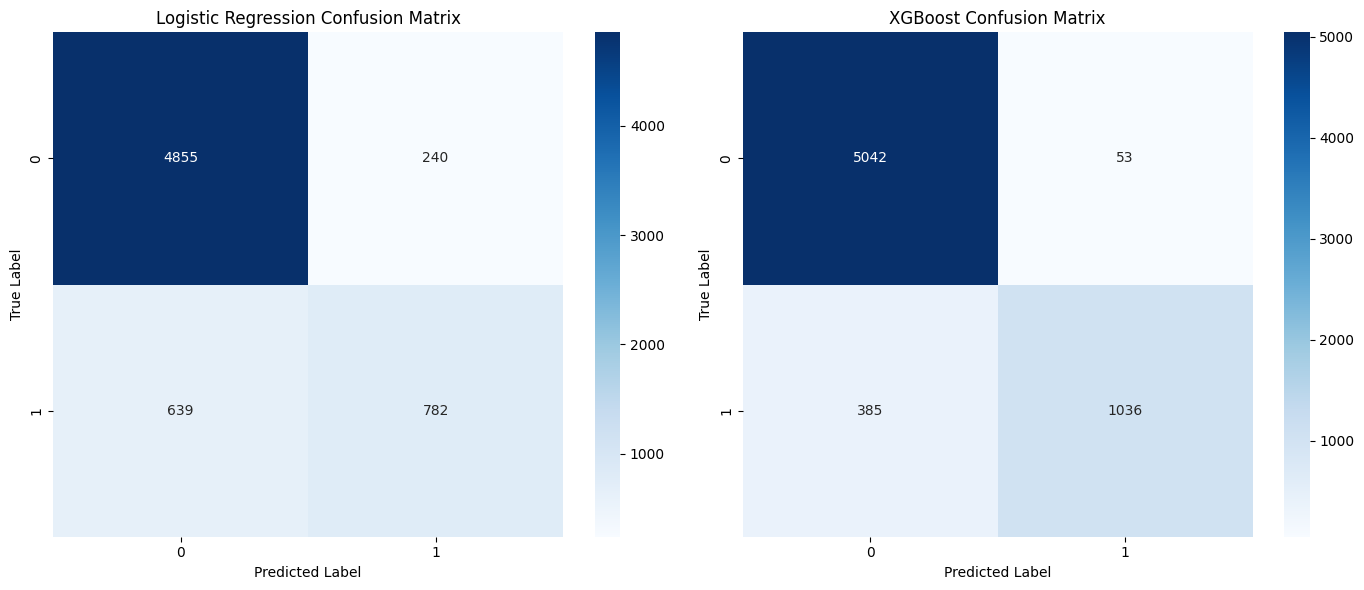

In [17]:
# ----------------- Step 5: Visualize the Confusion Matrices -----------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix for Logistic Regression
cm_logreg = confusion_matrix(y_val, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_val, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()


## Hyperparameter Tuning for XGBoost and Saving Models

Import Libraries for Hyperparameter Tuning & Saving Models

In [18]:
# Import necessary libraries for hyperparameter tuning and saving models
from sklearn.model_selection import GridSearchCV
import joblib
import os
from google.colab import drive
from xgboost import XGBClassifier


Define Hyperparameter Grid & Run GridSearchCV

In [19]:
# ----------------- Step 1: Hyperparameter Tuning with GridSearchCV -----------------
print("--- Starting Hyperparameter Tuning for XGBoost ---")

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
}

# Re-initialize the XGBoost Classifier
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(X_train_processed, y_train)


--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:09:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=2)

Get Best Parameters & Update Model

In [20]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("\n--- Hyperparameter Tuning Complete ---")
print("Best parameters found: ", best_params)
print("Best ROC AUC score on cross-validation: {:.4f}".format(best_score))

# Update the XGBoost model with the best parameters found
final_xgb_model = grid_search.best_estimator_



--- Hyperparameter Tuning Complete ---
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best ROC AUC score on cross-validation: 0.9433


Save Preprocessor & Final Model to Google Drive

In [21]:
# ----------------- Step 2: Save the Preprocessor and the Final Model -----------------
print("\n--- Saving the Preprocessor and Final Model ---")

# Define the path in your Google Drive to save the files
save_path = '/content/drive/MyDrive/my_project_artifacts'
os.makedirs(save_path, exist_ok=True)

# Save the preprocessor pipeline
preprocessor_filename = 'preprocessor.joblib'
preprocessor_filepath = os.path.join(save_path, preprocessor_filename)
joblib.dump(preprocessor, preprocessor_filepath)
print(f"Preprocessor saved to: {preprocessor_filepath}")

# Save the final, tuned XGBoost model
model_filename = 'final_xgb_model.joblib'
model_filepath = os.path.join(save_path, model_filename)
joblib.dump(final_xgb_model, model_filepath)
print(f"Final model saved to: {model_filepath}")



--- Saving the Preprocessor and Final Model ---
Preprocessor saved to: /content/drive/MyDrive/my_project_artifacts/preprocessor.joblib
Final model saved to: /content/drive/MyDrive/my_project_artifacts/final_xgb_model.joblib


Verify Files Were Saved

In [22]:
# Optional: Verify the saved files exist
print("\n--- Verifying Saved Files ---")
if os.path.exists(preprocessor_filepath) and os.path.exists(model_filepath):
    print("Files successfully saved to Google Drive.")
else:
    print("Error: Files were not saved correctly.")


--- Verifying Saved Files ---
Files successfully saved to Google Drive.


## Load Saved Model & Preprocessor, Evaluate on Holdout Test Set

Import Libraries & Setup

In [23]:
# Import necessary libraries
import pandas as pd
import joblib
import os
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Assuming you have the original data splits from Phase 1 ---
# (df, X, y, X_holdout_test, y_holdout_test)


Load Saved Preprocessor & Final Model

In [24]:
# ----------------- Step 1: Load the Saved Preprocessor and Final Model -----------------
print("--- Loading the saved preprocessor and final model from Google Drive ---")

# Define the path where you saved the files
load_path = '/content/drive/MyDrive/my_project_artifacts'
preprocessor_filepath = os.path.join(load_path, 'preprocessor.joblib')
model_filepath = os.path.join(load_path, 'final_xgb_model.joblib')

# Check if the files exist before attempting to load
if not os.path.exists(preprocessor_filepath) or not os.path.exists(model_filepath):
    print("Error: Files not found. Please ensure the saving step was completed successfully.")
else:
    # Load the preprocessor pipeline
    preprocessor = joblib.load(preprocessor_filepath)
    print("Preprocessor loaded successfully.")

    # Load the final, tuned XGBoost model
    final_xgb_model = joblib.load(model_filepath)
    print("Final XGBoost model loaded successfully.")


--- Loading the saved preprocessor and final model from Google Drive ---
Preprocessor loaded successfully.
Final XGBoost model loaded successfully.


Preprocess Holdout Test Data & Predict

In [25]:
    # ----------------- Step 2: Preprocess the Holdout Test Data -----------------
    print("\n--- Preprocessing the Holdout Test Set ---")

    # Apply the loaded preprocessor to the raw holdout test data
    # The preprocessor will handle scaling and one-hot encoding on this new data
    X_test_processed = preprocessor.transform(X_holdout_test)
    print("Holdout test data preprocessed successfully.")

    # ----------------- Step 3: Make Final Predictions and Evaluate -----------------
    print("\n--- Making final predictions and evaluating the model on the Holdout Test Set ---")

    # Make predictions on the preprocessed holdout test data
    y_pred_final = final_xgb_model.predict(X_test_processed)
    y_pred_proba_final = final_xgb_model.predict_proba(X_test_processed)[:, 1]

    # Evaluate the final model's performance
    print("Final Model Performance on Holdout Test Set:")
    print("Accuracy: {:.4f}".format(accuracy_score(y_holdout_test, y_pred_final)))
    print("Precision: {:.4f}".format(precision_score(y_holdout_test, y_pred_final)))
    print("Recall: {:.4f}".format(recall_score(y_holdout_test, y_pred_final)))
    print("F1-Score: {:.4f}".format(f1_score(y_holdout_test, y_pred_final)))
    print("ROC AUC Score: {:.4f}".format(roc_auc_score(y_holdout_test, y_pred_proba_final)))



--- Preprocessing the Holdout Test Set ---
Holdout test data preprocessed successfully.

--- Making final predictions and evaluating the model on the Holdout Test Set ---
Final Model Performance on Holdout Test Set:
Accuracy: 0.9348
Precision: 0.9690
Recall: 0.7243
F1-Score: 0.8290
ROC AUC Score: 0.9501


Visualize Confusion Matrix


--- Visualizing the Final Confusion Matrix ---


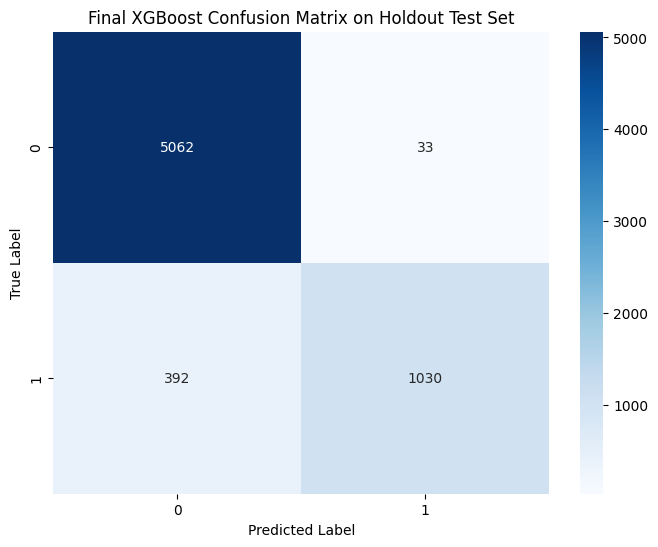

In [26]:
    # ----------------- Step 4: Visualize Final Confusion Matrix -----------------
    print("\n--- Visualizing the Final Confusion Matrix ---")
    cm_final = confusion_matrix(y_holdout_test, y_pred_final)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
    plt.title('Final XGBoost Confusion Matrix on Holdout Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
